# Data Science Project Final Report 

### Group 3: Sophie Heringa, Bao Anh Le, Lucia Otcenasek (14473367), and Miles Cui

# Introduction

## Background
The purpose of this project is to apply what we have learned in this course to a real-world problem, and assist Frank Wood's research group in the Computer Science department with their recruitment efforts. Specifically, our groups Research Question is targeted towards answering the First of their Three Broad Questions of Interest posed to us, as follows:
"**Question 1:** *What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"("Project Planning Stage: Individual")*

## Data Collection Method
The data is collected by a research group in Computer Science at UBC led by Frank Wood using a custom Minecraft server that logged voluntary gameplay.


## Research Question
Can Age and Played Hours make quality predictions of Subscription Status in the `players` dataset? 

## Described Dataset 

Run this cell to load all necessary R packages: 

In [12]:
library(tidyverse)
library(scales)
library(RColorBrewer)
library(tidymodels)

In [13]:
# reading in the "players" dataset" 
players <- read_csv("data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


<font size="4"> **Descriptions of "players":**

    - The players dataset contains 196 observations and 7 variables
| Variable Name | Data type | Meaning | 
|----------|-----------|---------|
| experience | character | Player's self-identified experience level |
| subscribe | logical | Whether the player subscribes to a game newsletter (TRUE or FALSE) |
| hashedEmail | character | Hashed version of a player's email | 
| played_hours | double | Total hours of playtime of a player| 
| name | character | Player's name | 
| gender | character |  Player's gender | 
| Age | double | Player's age |

<font size="4"> **Potential Issues:**
- subscribe needs to be converted from logical to factor for classification
- This is unnecessary for our purposes, but Age should technically be an integer
- Null values should be removed
- Possible feature interactions, and sampling bias that we can't detect just by looking at data
- Limitations in reliability of data if we can't see the whole population of Minecraft players

# Methods & Results

## Project Rundown/Description

This project involves K-NN classification using 2 predictor variables from the `players` dataset: `played_hours` and `Age`. The steps of the predictive analysis is listed below: 

1. Load the dataset `players`
2. Select only the `subscribe`, `played_hours`, and `Age` variables/columns
3. Change `subscribe` from `lgl` to `fct`
4. Create a visualization involving setting the predictive variables as the x and y axis, and coloring them by the variable of interest, `subscribe`
5. Split the data into a 70-30 ratio of training and testing data, respectively
6. Perform 5-fold cross validation on the training data, then picking the K with the highest accuracy
7. Train another model using the previously selected K to perform classification on the testing set
8. Examine accuracy (recall and precision is not needed since there is no positive variable

The process will be shown below: 

### STEP 1: Loading the data set

In [14]:
# Reading the dataset
# players_full <- read_csv("data/players.csv") what we started with 
url <- "https://raw.githubusercontent.com/Ada-Lov3lace/project_final_2/refs/heads/main/data/players.csv"
players_full <- read_csv(url) # to make the data reprodicible. We manually checked to see that the K value was unaffected, and would make appropriate changes if needed
head(players_full)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### STEP 2 & 3: Data wrangling 

In [15]:
# Wrangling the data into the preferred/tidy format to perform predictive analysis 
players_clean <- players_full |>
    select(subscribe, played_hours, Age) |> # selecting the required variables 
    mutate(subscribe = as_factor(subscribe)) |> # changing the variable of interest to <fct> type 
    filter(!is.na(Age), !is.na(played_hours), played_hours > 0)
head(players_clean)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.1,47
TRUE,1.6,23


### STEP 4: Creating visualizations

Now that the data has been wrangled into the preferred and tidy format for the predictive analysis, let's create a visualization of the predictors and the variables of interest

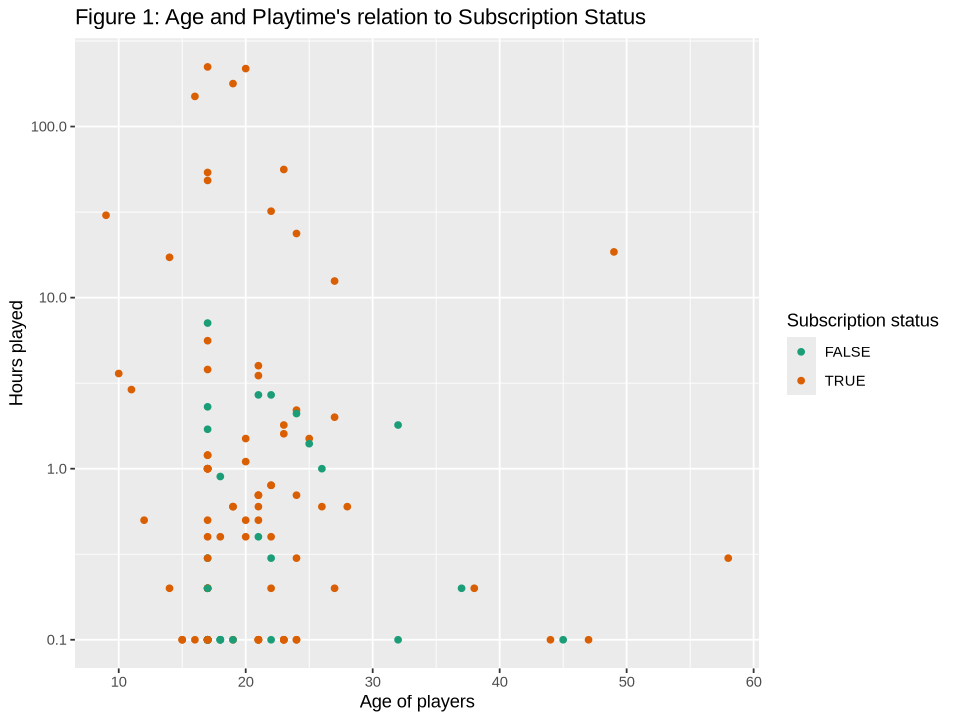

In [16]:
# Creating the visualization 
options(repr.plot.width = 8, repr.plot.height = 6)
players_plot <- players_clean |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Age of players", y = "Hours played", color = "Subscription status", 
         title = "Figure 1: Age and Playtime's relation to Subscription Status") +
    theme(element_text(size = 14)) +
    scale_y_log10() +
    scale_color_brewer(palette = "Dark2") 
players_plot

Note that the y scale for playtime is scaled logarithmically, which essentially ignores the data with a playtime of 0 as log(0) isn't real. The analysis below disregards data where playtime is 0

There are a few observations that can be made from the visualization above: 

1. There is no visible relationship between player age and playtime.
2. Most players are within the age range between 20 - 30 years old.
3. Most players played between 0 - 10 hours.
4. Orange datapoints (TRUE subscription status) are spread throughout the top and bottom of the left hand side
5. Importantly, the green datapoints (FALSE subscription status) mostly reside in the bottom left, possibly corresponding to fewer played hours for non-subscribers than subscribers (further investigation in second visualization)

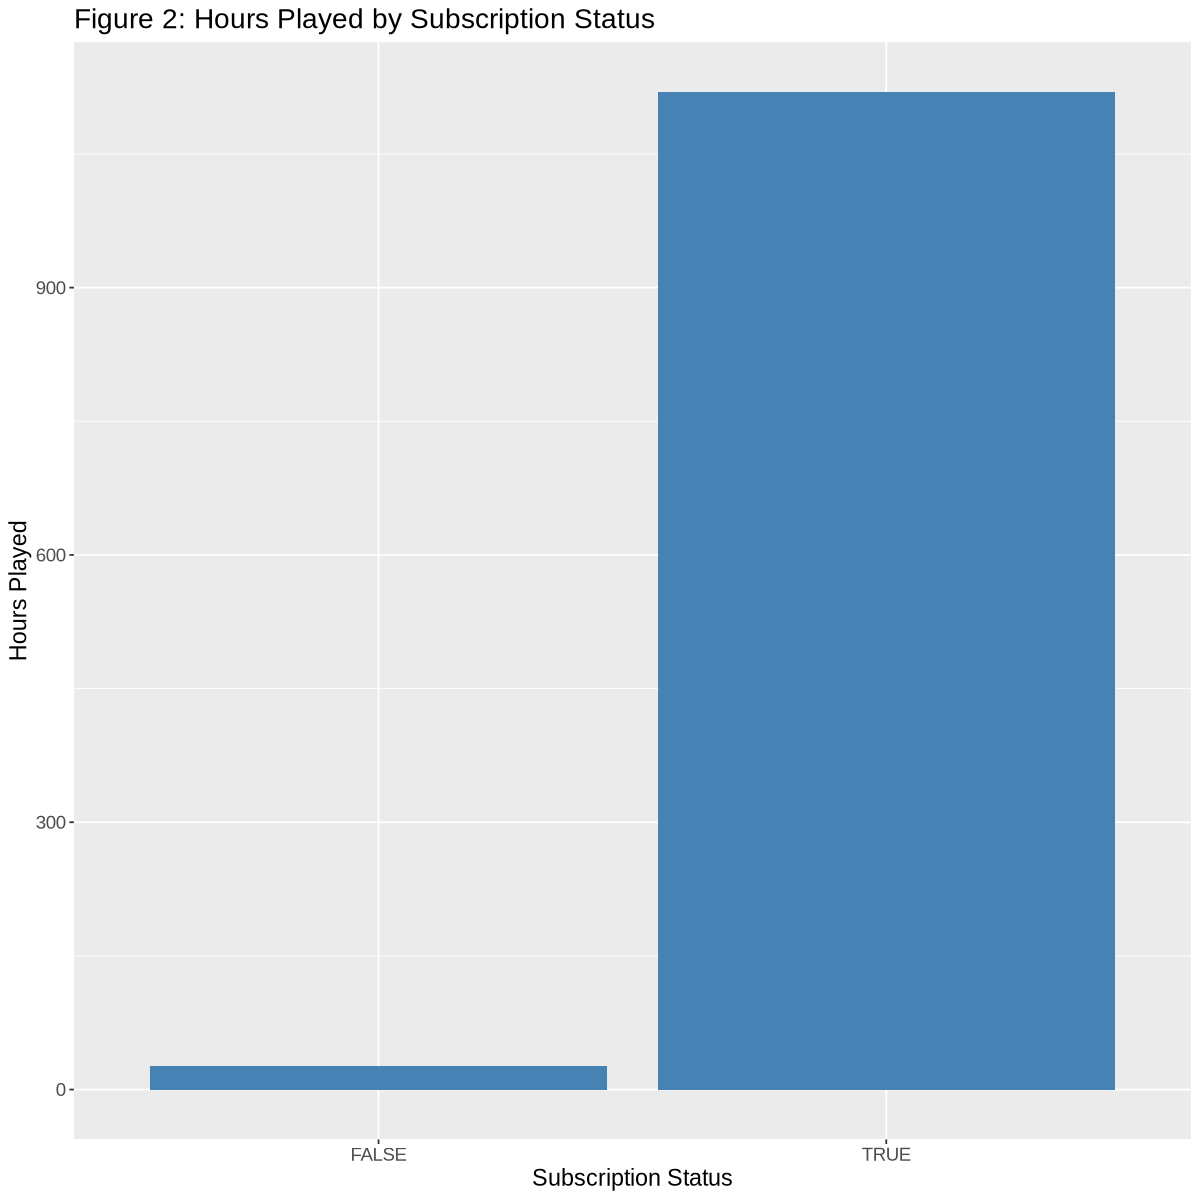

In [17]:
# creating 2nd visualization 
options(repr.plot.width = 10, repr.plot.height = 10)
subscription_played_hrs <- players_clean |>
                           ggplot(aes(x = subscribe, y = played_hours)) + 
                            geom_bar(stat = "identity", fill = "steelblue") +
                            labs(x = "Subscription Status", y = "Hours Played", 
                                 title = "Figure 2: Hours Played by Subscription Status") +
                            theme(text = element_text(size = 14))
                            
subscription_played_hrs

Observations:
1. Significantly fewer hours played for non-subscribers (subscription status = FALSE) than subscribers (subscription status = TRUE)
2. Significant evidence that there's a relationship between subscription status and playtime
3. Can infer that played hours is likely a good predictor for predicting subscription status with K-NN classification  

## Step 5: Creating the Training and Testing Set 

In [18]:
set.seed(123)
# creating a 70 - 30 split of players_clean
players_split <- initial_split(players_clean, prop = 0.7, strata = subscribe) 
players_training <- training(players_split) # training data
players_testing <- testing(players_split) # testing data

## Step 6: Performing 5 Fold Cross-validation on `players_training`

In [19]:
set.seed(2019)
# creating the specifications for the model 
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# creating the recipe 
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
players_recipe 


set.seed(2019)
# creating the 5 folds for cross-validation
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

# setting up the workflow
players_workflow <- workflow() |>
  add_model(players_spec) |>
  add_recipe(players_recipe)
players_workflow

# creating the K values (from 1 to 10) 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1)) 

# fitting the data into a workflow and finding the best K
players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()
head(players_results)

# finding the best K based on accuracy
best_players_k <- players_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
print("Best K:")
best_players_k



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6003571,5,0.04512030,Preprocessor1_Model01
1,roc_auc,binary,0.4537879,5,0.05368107,Preprocessor1_Model01
2,accuracy,binary,0.6003571,5,0.04512030,Preprocessor1_Model02
2,roc_auc,binary,0.5765152,5,0.03563728,Preprocessor1_Model02
3,accuracy,binary,0.7340476,5,0.03369142,Preprocessor1_Model03
3,roc_auc,binary,0.6188763,5,0.05796211,Preprocessor1_Model03


[1] "Best K:"


[1] 7

## Step 7: Final Workflow for Training and Testing the KNN classifier on the Testing Set 

In [75]:
# defining the final KNN model
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_players_k) |>
  set_engine("kknn") |>
  set_mode("classification")

# creating the final workflow 
final_workflow <- workflow() |>
  add_model(final_spec) |>
  add_recipe(players_recipe) |> 
  fit(data = players_training)

# generating predictions on testing data
players_predictions <- final_workflow |>
  predict(new_data = players_testing) |>
  bind_cols(players_testing)

# calculating performance metrics
players_summary <- players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)
players_summary

# confusion matrix analysis
conf_mat(players_predictions, truth = subscribe, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7647059
kap,binary,0.0000000


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      8   26

## Step 8: Visualizing how the Mean Accuracy of the KNN Model Changes with Different Numbers of Neighbors (k)

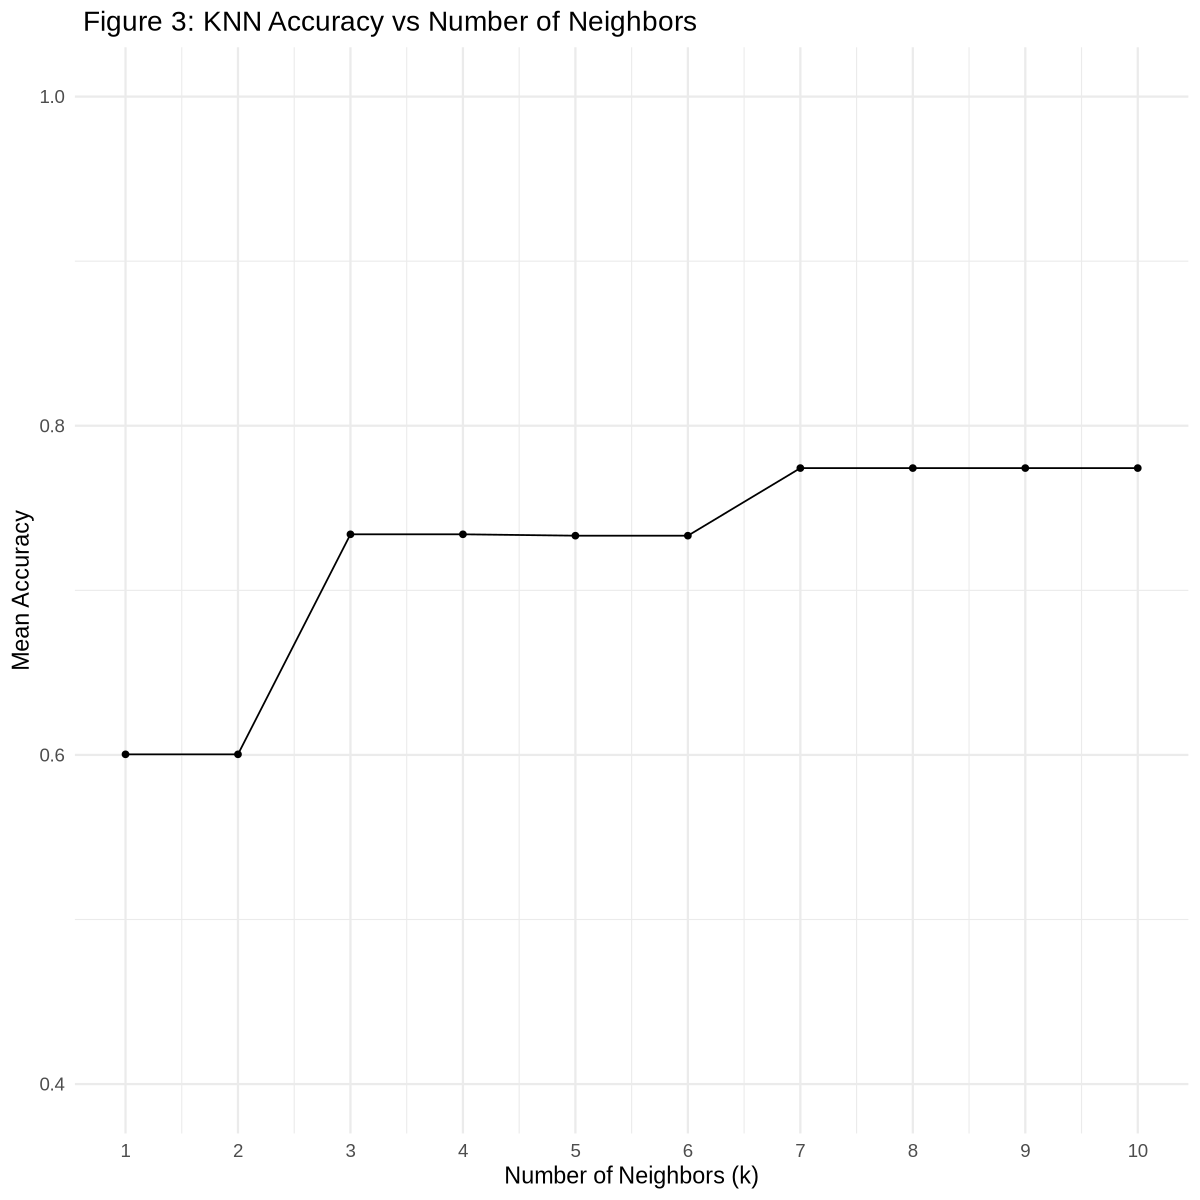

In [76]:
# filter out only the accuracy results from the KNN tuning
players_accuracy_results <- players_results |> 
  filter(.metric == "accuracy")

# create a plot 
accuracy_versus_k <- ggplot(players_accuracy_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (k)", y = "Mean Accuracy",
       title = " Figure 3: KNN Accuracy vs Number of Neighbors") +
  scale_x_continuous(breaks = seq(1, 10, by = 1)) +
  scale_y_continuous(limits = c(0.4, 1.0)) +
  theme_minimal(base_size = 14)

accuracy_versus_k


# Discussion 

## Brief summary of procedure

The goal of this data analysis is to predict a player's subscription status based on their age and play time. K-NN Classification was used to address this analysis. The dataset `players` was split into a 70/30 ratio for the training and testing data, respectively. 5 fold cross-validation was then done on the scaled/standardized training model to select the value of K that yeilded the highest accuracy. The model spec was then set to that K value. Finally, the properly trained model was used to assess/predict the observations of the testing set. Accuracy was then assessed using `collect_metrics`.

## Results, Expectations, Implications, and Limitations 

The accuracy of the K-NN Classification model was assessed to be around 76.4%. Meaning that given a new observation, the model will correctly predict the subscription status with a confidence of ~80%.

This accuracy was within the range of expected values that our team expected as the best K was chosen using a valid and reliable method.

A limitation of this prediction model is the lack of recall and precision analysis. Since most players are subscribed, the model might produce consistent error when "subscribed", or `TRUE` is the positive variable. 

This model can serve as a general predictor for any future actions where subscription status needs to be optimized. For example, recruiting players who are most likely to subscribe to the game newsletter. 

This research analysis created a model that predicts the subscription status based on relevant variables. However, there is a knowledge regarding the dependence of individual variables. For instance, a casual question could be whether a change in `Age` will cause a related change in `played_hours`. 

## References

No references used